# Getting Global Features

In [27]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mahotas
import cv2
import os
import h5py

In [28]:
# fixed-sizes for image
fixed_size = tuple((500, 500))

# path to training data
train_path = "dataset/train"

# no.of.trees for Random Forests
num_trees = 100

# bins for histogram
bins = 8

# train_test_split size
test_size = 0.20

# seed for reproducing same results
seed = 9

In [29]:
# feature-descriptor-1: Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

# feature-descriptor-2: Haralick Texture
def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick

# feature-descriptor-3: Color Histogram
def fd_histogram(image, mask=None):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()

In [30]:
# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()
print(train_labels)

# empty lists to hold feature vectors and labels
global_features = []
labels = []

i, j = 0, 0
k = 0

# num of images per class
images_per_class = 80

# loop over the training data sub-folders
for training_name in train_labels:
    # join the training data path and each species training folder
    dir = os.path.join(train_path, training_name)

    # get the current training label
    current_label = training_name
    files = os.listdir(dir)
    k = 1
    # loop over the images in each sub-folder
    for file in files:
        if '.jpg' in file or '.png' in file:
            # get the image file name
            file = dir + "/" + file

            # read the image and resize it to a fixed-size
            image = cv2.imread(file)
#             print file
            image = cv2.resize(image, fixed_size)

            ####################################
            # Global Feature extraction
            ####################################
            fv_hu_moments = fd_hu_moments(image)
            fv_haralick   = fd_haralick(image)
            fv_histogram  = fd_histogram(image)

            ###################################
            # Concatenate global features
            ###################################
            global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

            # update the list of labels and feature vectors
            labels.append(current_label)
            global_features.append(global_feature)

            i += 1
            k += 1
    print "[STATUS] processed folder: {}".format(current_label)
    j += 1

print "[STATUS] completed Global Feature Extraction..."

# get the overall feature vector size
print "[STATUS] feature vector size {}".format(np.array(global_features).shape)

# get the overall training label size
print "[STATUS] training Labels {}".format(np.array(labels).shape)

['birds', 'drones']
[STATUS] processed folder: birds
[STATUS] processed folder: drones
[STATUS] completed Global Feature Extraction...
[STATUS] feature vector size (109, 532)
[STATUS] training Labels (109,)


In [31]:
# encode the target labels
targetNames = np.unique(labels)
le = LabelEncoder()
target = le.fit_transform(labels)
print "[STATUS] training labels encoded..."

# normalize the feature vector in the range (0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print "[STATUS] feature vector normalized..."

print "[STATUS] target labels: {}".format(target)
print "[STATUS] target labels shape: {}".format(target.shape)

# save the feature vector using HDF5
h5f_data = h5py.File('output/data.h5', 'w')
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

h5f_label = h5py.File('output/labels.h5', 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

h5f_data.close()
h5f_label.close()

print "[STATUS] end of training.."

[STATUS] training labels encoded...
[STATUS] feature vector normalized...
[STATUS] target labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[STATUS] target labels shape: (109,)
[STATUS] end of training..


# Training Classifiers on the saved global features

In [32]:
import h5py
import numpy as np
import os
import glob
import cv2
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.externals import joblib

In [33]:
models = []
models.append(('LR', LogisticRegression(random_state=9)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=9)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=9)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=9)))

In [34]:
# variables to hold the results and names
results = []
names = []
scoring = "accuracy"

# import the feature vector and trained labels
h5f_data = h5py.File('output/data.h5', 'r')
h5f_label = h5py.File('output/labels.h5', 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of the feature vector and labels
print "[STATUS] features shape: {}".format(global_features.shape)
print "[STATUS] labels shape: {}".format(global_labels.shape)

[STATUS] features shape: (109, 532)
[STATUS] labels shape: (109,)


In [35]:
print "[STATUS] training started..."

# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print "[STATUS] splitted train and test data..."
print "Train data  : {}".format(trainDataGlobal.shape)
print "Test data   : {}".format(testDataGlobal.shape)
print "Train labels: {}".format(trainLabelsGlobal.shape)
print "Test labels : {}".format(testLabelsGlobal.shape)

# filter all the warnings
import warnings
warnings.filterwarnings('ignore')

[STATUS] training started...
[STATUS] splitted train and test data...
Train data  : (87, 532)
Test data   : (22, 532)
Train labels: (87,)
Test labels : (22,)


LR: 0.718056 (0.146599)
LDA: 0.529167 (0.211773)
KNN: 0.663889 (0.163252)
CART: 0.748611 (0.127665)
RF: 0.762500 (0.131974)
NB: 0.713889 (0.138221)
SVM: 0.355556 (0.074068)


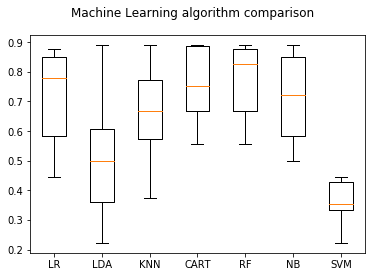

In [36]:
# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=10, random_state=7)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

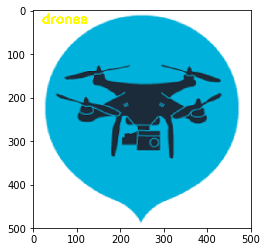

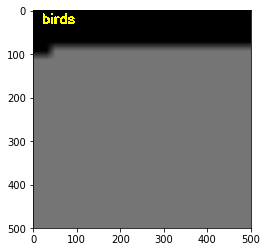

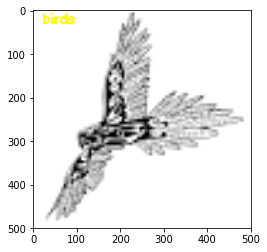

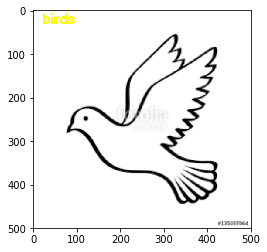

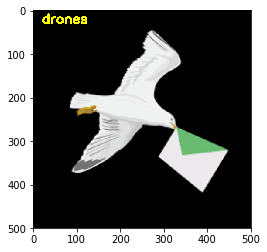

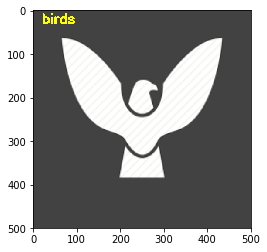

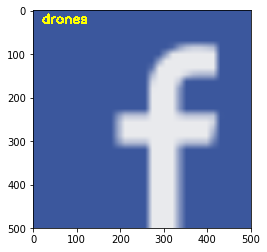

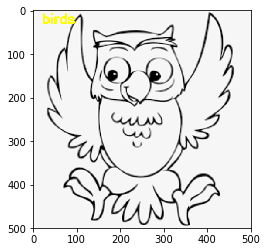

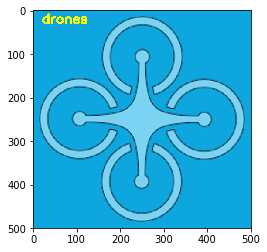

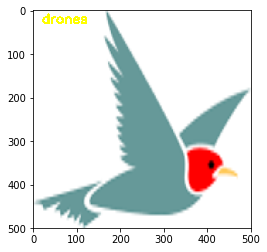

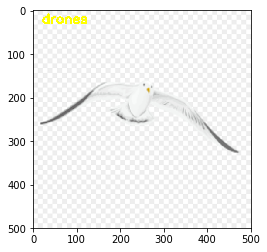

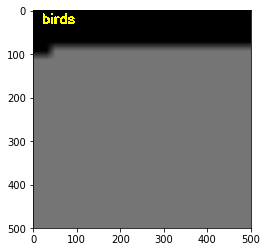

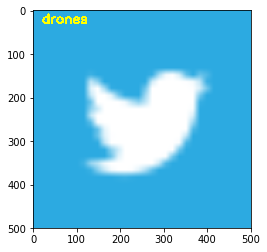

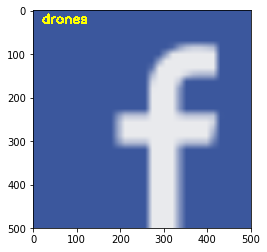

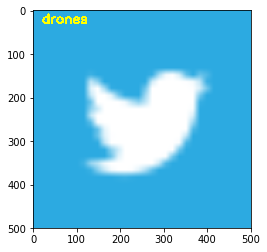

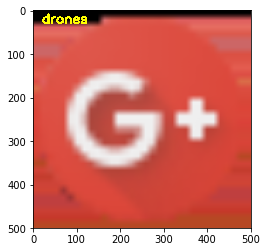

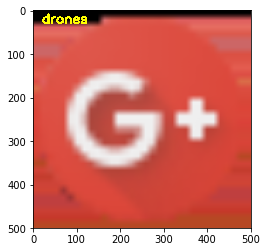

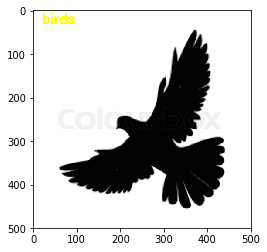

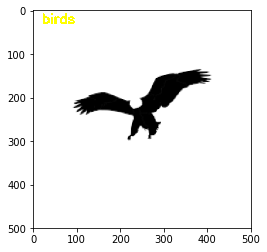

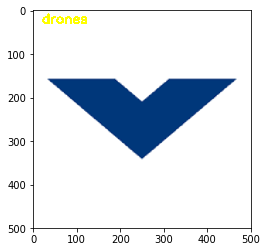

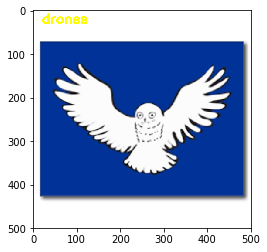

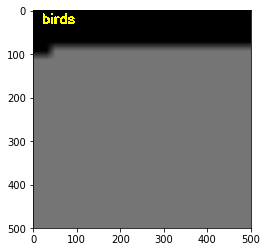

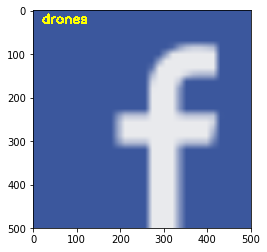

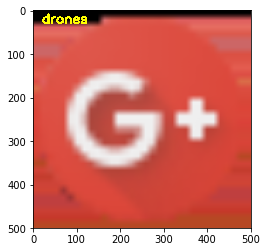

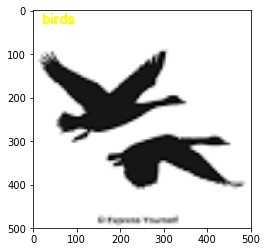

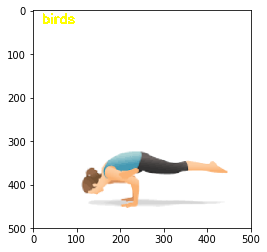

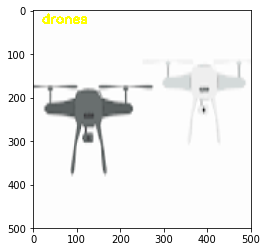

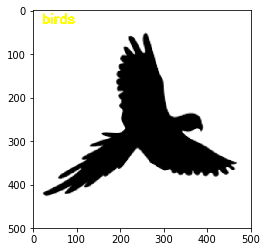

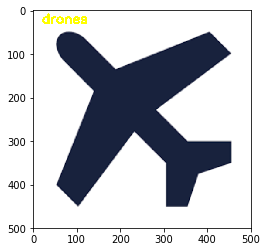

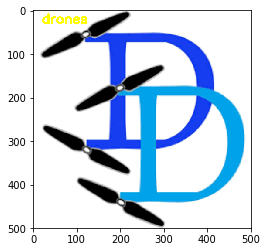

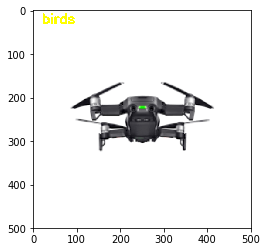

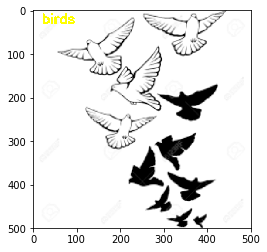

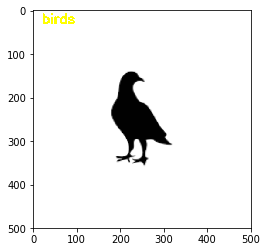

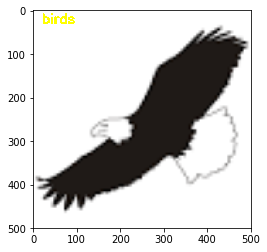

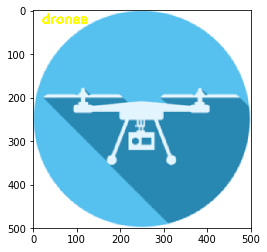

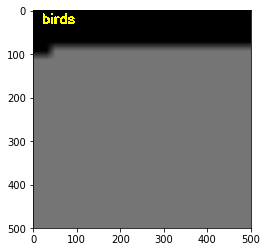

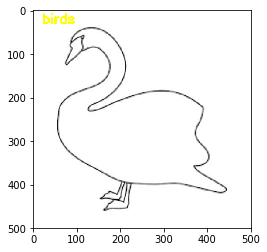

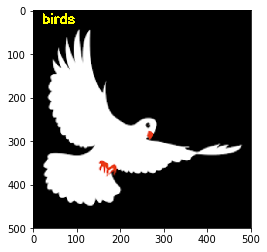

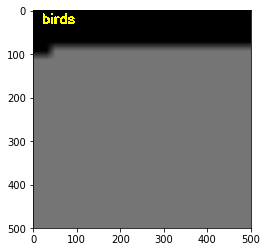

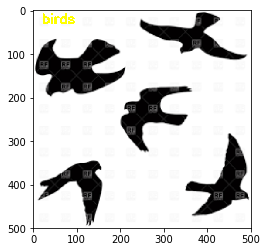

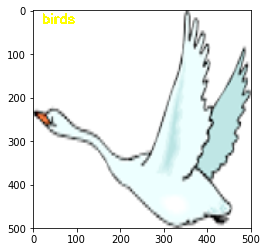

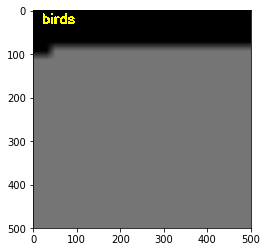

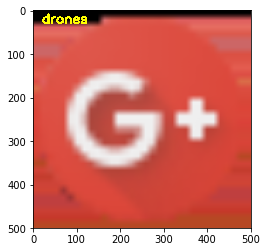

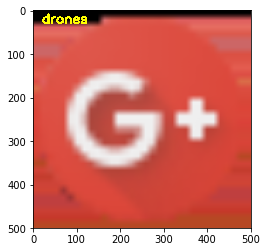

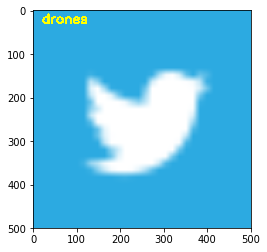

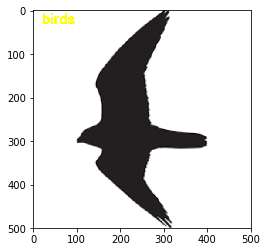

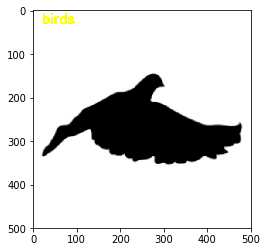

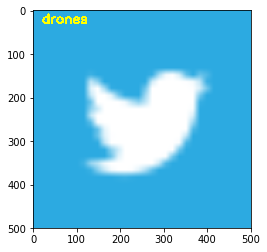

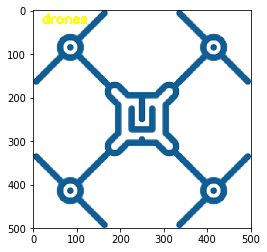

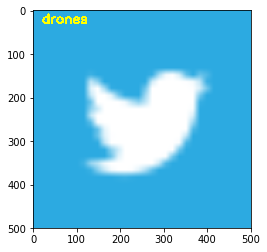

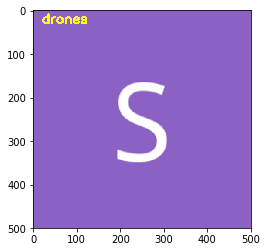

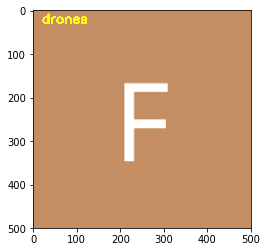

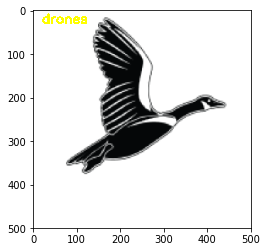

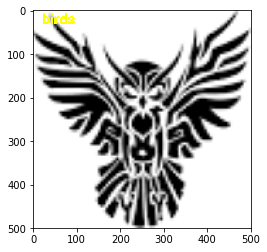

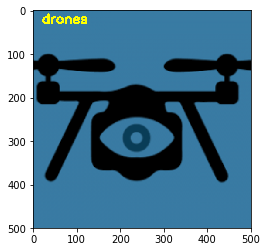

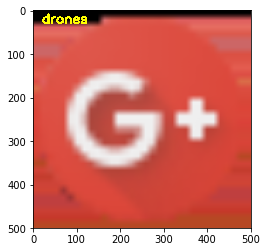

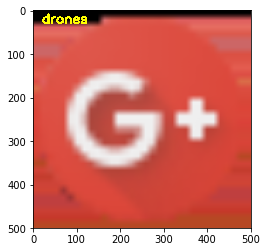

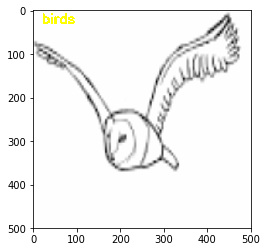

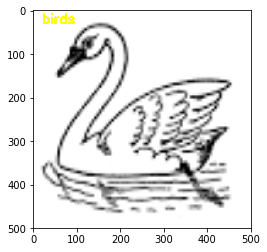

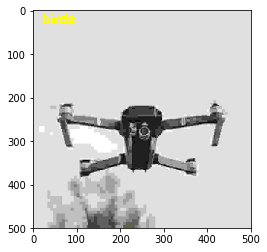

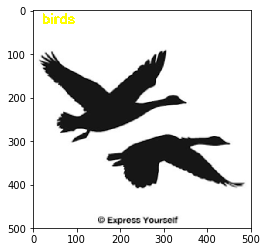

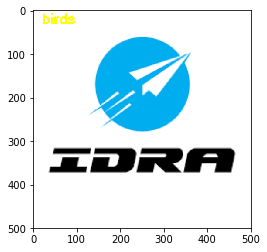

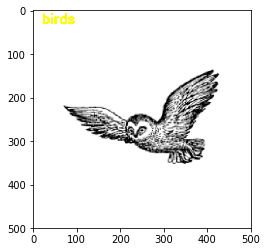

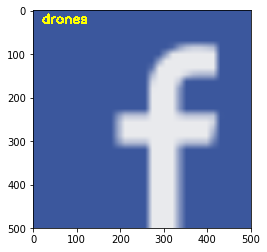

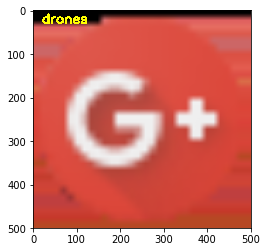

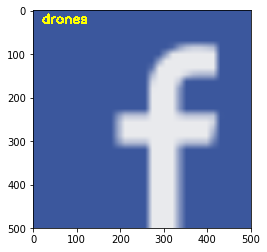

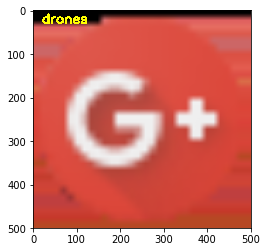

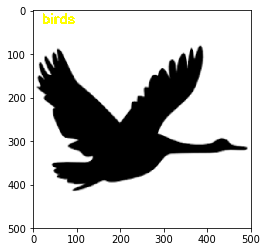

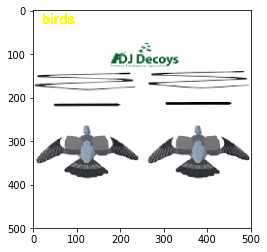

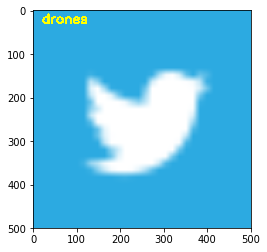

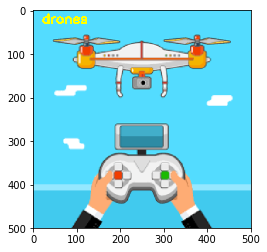

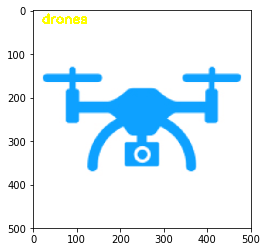

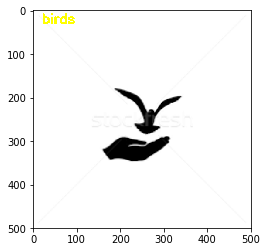

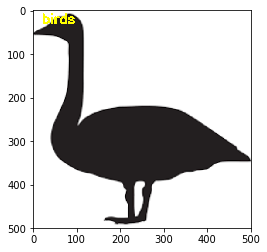

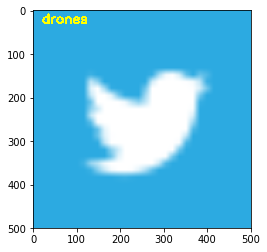

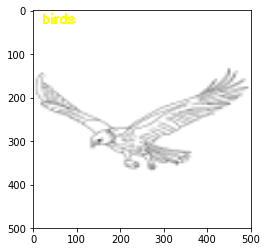

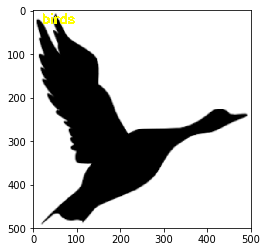

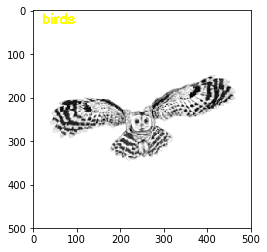

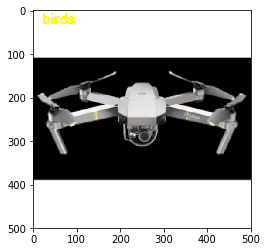

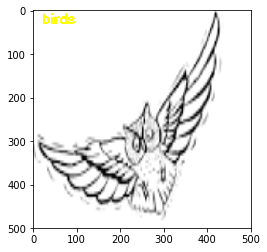

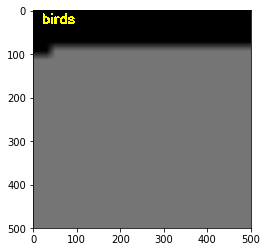

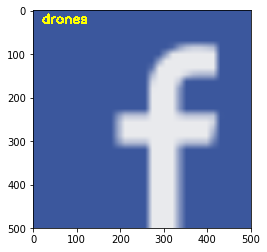

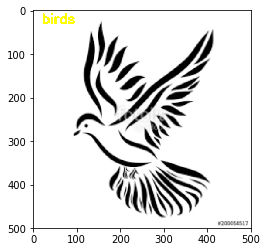

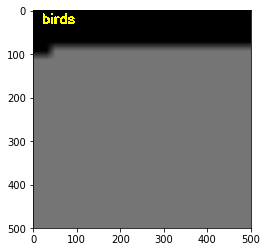

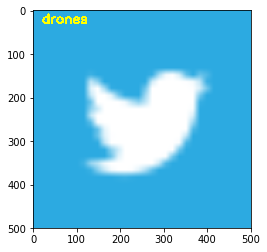

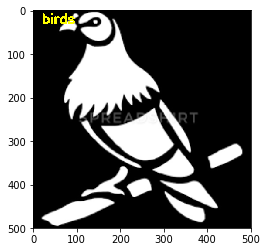

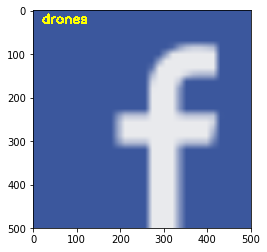

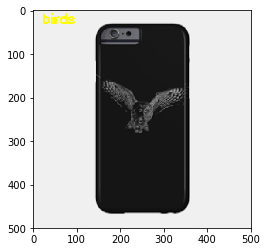

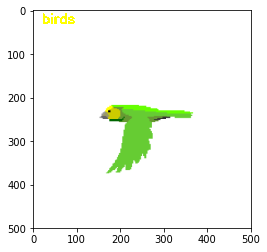

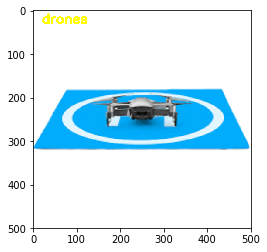

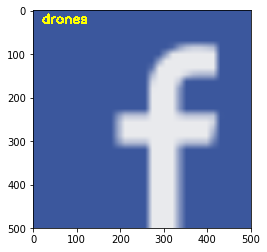

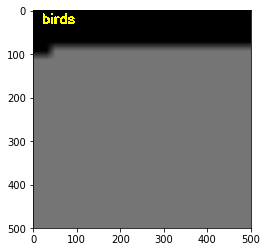

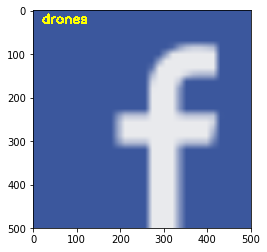

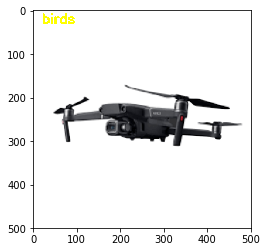

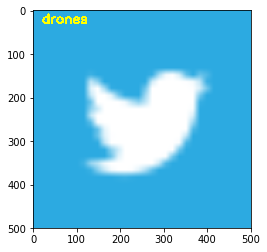

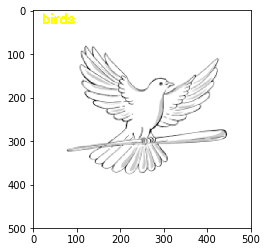

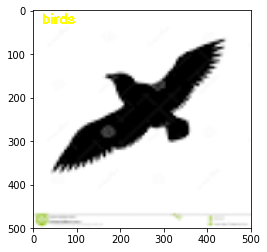

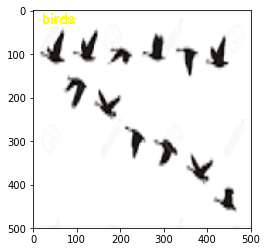

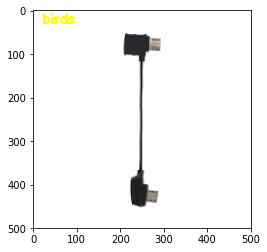

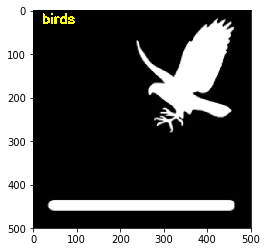

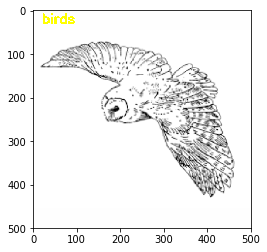

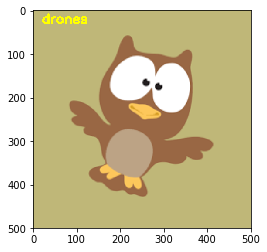

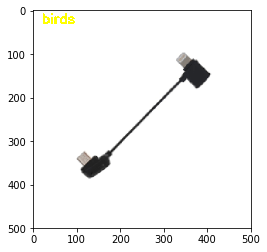

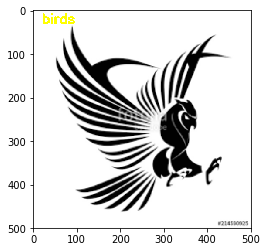

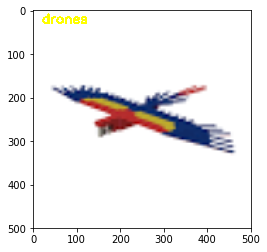

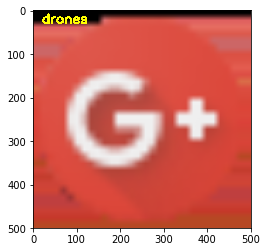

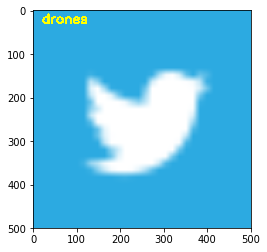

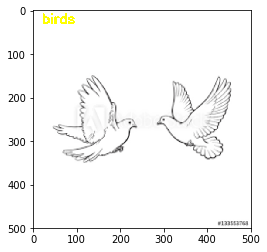

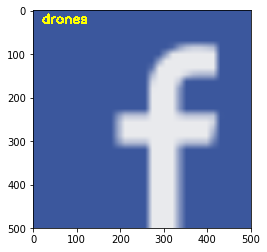

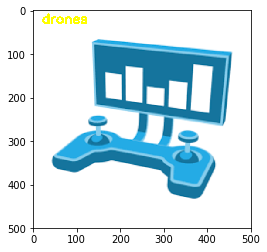

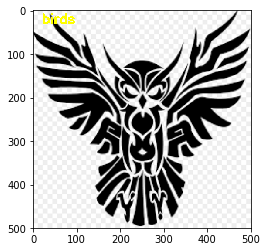

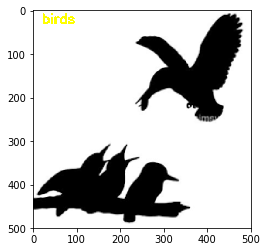

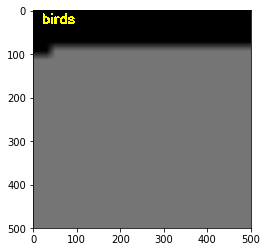

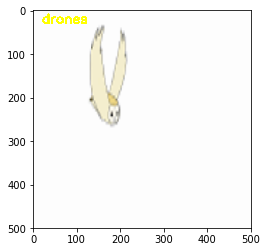

In [38]:
#-----------------------------------
# TESTING OUR MODEL
#-----------------------------------

# to visualize results
import matplotlib.pyplot as plt
%matplotlib inline

# create the model - Random Forests
clf  = RandomForestClassifier(n_estimators=100, random_state=9)

# fit the training data to the model
clf.fit(trainDataGlobal, trainLabelsGlobal)

# path to test data
test_path = "dataset/test"

files = os.listdir(test_path)
# loop through the test images
for file in files:
    if '.jpg' in file or '.png' in file:
        # read the image
#         print file
        file = test_path + "/" + file
        image = cv2.imread(file)

        # resize the image
        image = cv2.resize(image, fixed_size)

        ####################################
        # Global Feature extraction
        ####################################
        fv_hu_moments = fd_hu_moments(image)
        fv_haralick   = fd_haralick(image)
        fv_histogram  = fd_histogram(image)

        ###################################
        # Concatenate global features
        ###################################
        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

        # predict label of test image
        prediction = clf.predict(global_feature.reshape(1,-1))[0]

        # show predicted label on image
        cv2.putText(image, train_labels[prediction], (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)

        # display the output image
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.show()

In [ ]:
print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, y_pred)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, y_pred))